# Computer Vision Analysis
### Keras Grid Search of CNN models
#### By Ronny Toribio, Kadir O. Altunel, Michael Cook-Stahl
#### Based on [Hands on Machine Learning 2nd edition](https://github.com/ageron/handson-ml2/), [FER2013 candidate 1](https://www.kaggle.com/code/ritikjain00/model-training-fer-13) and [FER2013 candidate 2](https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition/notebook)

### Import modules

In [1]:
%matplotlib inline
import os
import os.path
import shutil
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint 
from google.colab import drive

### Constants

In [2]:
BATCH_SIZE = 32
IMAGE_ZOOM = 0.3
IMAGE_SHAPE = (48, 48)
INPUT_SHAPE = (48, 48, 1)
TRAIN_DIR = os.path.join("fer2013", "train")
TEST_DIR = os.path.join("fer2013", "test")
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/Machine Learning/GridSearch"

### Mount Google Drive and unzip dataset

In [3]:
drive.mount('/content/drive')
os.makedirs(GOOGLE_DRIVE_PATH, exist_ok=True)
!unzip /content/drive/MyDrive/FER.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

### Load Facial Emotion Recognition dataset
#### training, validation, and testing

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=IMAGE_ZOOM, horizontal_flip=True,
                                   validation_split=0.10)
Xy_train = train_datagen.flow_from_directory(TRAIN_DIR, batch_size=BATCH_SIZE, 
                                   target_size=IMAGE_SHAPE, shuffle=True, subset="training",
                                   color_mode="grayscale", class_mode="categorical")

Xy_valid = train_datagen.flow_from_directory(TRAIN_DIR, batch_size=BATCH_SIZE, 
                                   target_size=IMAGE_SHAPE, shuffle=True, subset="validation",
                                   color_mode="grayscale", class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
Xy_test = test_datagen.flow_from_directory(TEST_DIR, batch_size=BATCH_SIZE,
                                   target_size=IMAGE_SHAPE, shuffle=True,
                                   color_mode="grayscale", class_mode="categorical")

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Build and compile CNN model

In [5]:
def build_model(main_activation, main_initializer, use_conv_block3=False):
    model = Sequential(name="cnn_model")
    # Convolution Block 0
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, input_shape=INPUT_SHAPE,
              name="conv_block_0_conv_layer_0_input"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_0_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid", name="conv_block_0_maxpool"))
    model.add(Dropout(0.25, name="conv_block_0_dropout"))

    # Convolution Block 1
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), name="conv_block_1_conv_layer_0"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), name="conv_block_1_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_1_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_1_maxpool"))
    model.add(Dropout(0.25, name="conv_block_1_dropout"))
        
    # Convolution Block 2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01),
              name="conv_block_2_conv_layer_0"))
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), 
              name="conv_block_2_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_2_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_2_maxpool"))
    model.add(Dropout(0.25, name="conv_block_2_dropout"))
    
    # Convolution Block 3
    if use_conv_block3:
        model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=main_activation,
                  kernel_initializer= main_initializer, kernel_regularizer=l2(0.01),
                  name="conv_block_3_conv_layer_0"))
        model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation=main_activation,
                  kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), 
                  name="conv_block_3_conv_layer_1"))
        model.add(BatchNormalization(name="conv_block_3_batchnorm"))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_3_maxpool"))
        model.add(Dropout(0.25, name="conv_block_3_dropout"))

    # Classification Block
    model.add(Flatten(name="class_block_flatten"))
    model.add(Dense(2048, activation=main_activation, kernel_initializer="he_normal",
              name="class_block_flatten_dense_0"))
    model.add(BatchNormalization(name="class_block_batchnorm"))
    model.add(Dropout(0.5, name="class_block_dropout"))
    model.add(Dense(7, activation="softmax", name="class_block_dense_output"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=["accuracy"])
    return model

def build_model_with_activation_layers(main_activation_layer, main_activation_name, main_initializer,
                                       use_conv_block3=False):
    model = Sequential(name="cnn_model")
    # Convolution Block 0
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=INPUT_SHAPE,
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_0_input"))
    model.add(main_activation_layer(name="conv_block_0_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same",
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_0_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_0_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid", name="conv_block_0_maxpool"))
    model.add(Dropout(0.25, name="conv_block_0_dropout"))

    # Convolution Block 1
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_1_conv_layer_0"))
    model.add(main_activation_layer(name="conv_block_1_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_1_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_1_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_1_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_1_maxpool"))
    model.add(Dropout(0.25, name="conv_block_1_dropout"))
        
    # Convolution Block 2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_2_conv_layer_0"))
    model.add(main_activation_layer(name="conv_block_2_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01), 
              kernel_initializer= main_initializer, name="conv_block_2_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_2_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_2_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_2_maxpool"))
    model.add(Dropout(0.25, name="conv_block_2_dropout"))
    
    # Convolution Block 3
    if use_conv_block3:
        model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
                  kernel_initializer= main_initializer, name="conv_block_3_conv_layer_0"))
        model.add(main_activation_layer(name="conv_block_3_{}_0".format(main_activation_name)))
        model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01), 
                  kernel_initializer= main_initializer, name="conv_block_3_conv_layer_1"))
        model.add(main_activation_layer(name="conv_block_3_{}_1".format(main_activation_name)))
        model.add(BatchNormalization(name="conv_block_3_batchnorm"))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_3_maxpool"))
        model.add(Dropout(0.25, name="conv_block_3_dropout"))

    # Classification Block
    model.add(Flatten(name="class_block_flatten"))
    model.add(Dense(2048, kernel_initializer= main_initializer, name="class_block_flatten_dense_0"))
    model.add(main_activation_layer(name="class_block_{}_0".format(main_activation_name)))
    model.add(BatchNormalization(name="class_block_batchnorm"))
    model.add(Dropout(0.5, name="class_block_dropout"))
    model.add(Dense(7, activation="softmax", name="class_block_dense_output"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=["accuracy"])
    return model



### Early stopping callback

In [6]:
early_stopping_cb = EarlyStopping(min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True)

### Reduce learning rate on plateau callback

In [7]:
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=7, min_l=1e-7, verbose=1)

### Grid Search Hyperparameters for our model

In [8]:
param_grid = [
    {"main_activation": ["relu", "elu"], "main_initializer":["he_normal"], "use_conv_block3": [True, False]},
    {"main_activation": ["selu"], "main_initializer":["lecun_normal"], "use_conv_block3": [True, False]},
    {"main_activation_layer": [LeakyReLU], "main_activation_name": ["leaky_relu"],
     "main_initializer":["he_normal"], "use_conv_block3": [True, False]}
]

best_model = None
best_model_accuracy = None
best_model_history = None
best_model_name = ""
convolution_blocks = [3, 4]
scores = {}

for params in list(ParameterGrid(param_grid)):
    cur_name = ""
    cur_model = None
    
    # Build model from paramters
    if "main_activation" in params:
        cur_name = "{}+{}+{}-convolution-blocks".format(params["main_activation"], params["main_initializer"],
                                     convolution_blocks[params["use_conv_block3"]])
        cur_model = build_model(**params)
    else:
        cur_name = "{}+{}+{}-convolution-blocks".format(params["main_activation_name"], params["main_initializer"],
                                     convolution_blocks[params["use_conv_block3"]])
        cur_model = build_model_with_activation_layers(**params)
    print(cur_name)
    if cur_model is None:
        continue
        
    # Save model architecture as JSON
    model_json = cur_model.to_json()
    with open(cur_name + ".json", "w") as f:
        f.write(model_json)
        
    # Train model
    csv_cb = CSVLogger(cur_name + "-training.csv")
    cur_weights = cur_name + "-weights.h5"
    checkpoint_cb = ModelCheckpoint(cur_weights, monitor = 'accuracy', verbose =1, 
                                    save_best_only = True, save_weights_only = True)
    history = cur_model.fit(Xy_train, epochs=80,
                            validation_data=(Xy_valid),
                            steps_per_epoch=Xy_train.n // BATCH_SIZE,
                            validation_steps=Xy_valid.n // BATCH_SIZE,
                            callbacks=[early_stopping_cb, reduce_lr_cb, 
                                       csv_cb, checkpoint_cb])
    
    # Save statistics and compare accuracies
    cur_model.load_weights(cur_weights)
    loss, accuracy = cur_model.evaluate(Xy_test)
    scores[accuracy] = [cur_name, loss]
    if best_model_accuracy is None or accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = cur_model
        best_model_history = history
        best_model_name = cur_name

relu+he_normal+4-convolution-blocks
Epoch 1/80
806/807 [============================>.] - ETA: 0s - loss: 63.8020 - accuracy: 0.2188
Epoch 1: accuracy improved from -inf to 0.21888, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==============================] - 40s 37ms/step - loss: 63.7899 - accuracy: 0.2189 - val_loss: 54.3613 - val_accuracy: 0.2553 - lr: 1.0000e-04
Epoch 2/80
807/807 [==============================] - ETA: 0s - loss: 44.0958 - accuracy: 0.2832
Epoch 2: accuracy improved from 0.21888 to 0.28320, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==============================] - 29s 36ms/step - loss: 44.0958 - accuracy: 0.2832 - val_loss: 37.2758 - val_accuracy: 0.2795 - lr: 1.0000e-04
Epoch 3/80
807/807 [==============================] - ETA: 0s - loss: 27.4735 - accuracy: 0.3169
Epoch 3: accuracy improved from 0.28320 to 0.31690, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==================

### Print best model

In [9]:
print("Best Model: {} Accuracy: {}".format(best_model_name, best_model_accuracy))

Best Model: relu+he_normal+3-convolution-blocks Accuracy: 0.6802730560302734


### Print model accuracies

In [10]:
for accuracy in sorted(scores.keys(), reverse=True):
    name, loss = scores[accuracy]
    print("Name: {} Accuracy: {} Loss: {}".format(name, accuracy, loss))

Name: relu+he_normal+3-convolution-blocks Accuracy: 0.6802730560302734 Loss: 1.0993871688842773
Name: relu+he_normal+4-convolution-blocks Accuracy: 0.6765115857124329 Loss: 1.0885995626449585
Name: leaky_relu+he_normal+4-convolution-blocks Accuracy: 0.6652270555496216 Loss: 1.05915367603302
Name: leaky_relu+he_normal+3-convolution-blocks Accuracy: 0.6634159684181213 Loss: 1.0441060066223145
Name: elu+he_normal+3-convolution-blocks Accuracy: 0.6528280973434448 Loss: 1.0537306070327759
Name: selu+lecun_normal+4-convolution-blocks Accuracy: 0.6447478532791138 Loss: 1.1209967136383057
Name: selu+lecun_normal+3-convolution-blocks Accuracy: 0.6354137659072876 Loss: 1.1144425868988037


### Convert histories into graph images

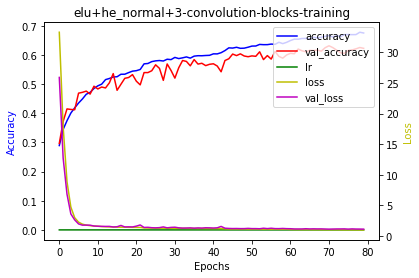

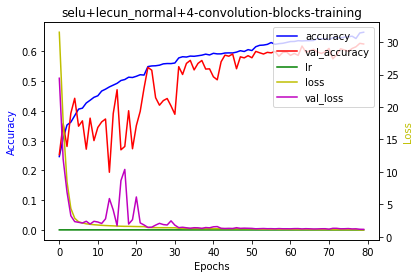

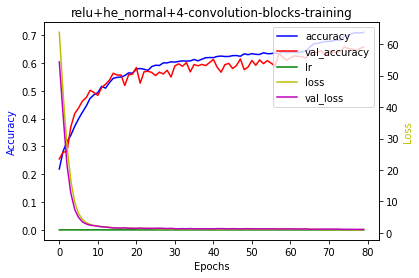

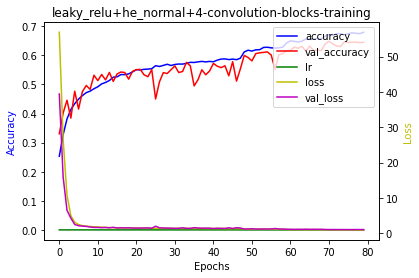

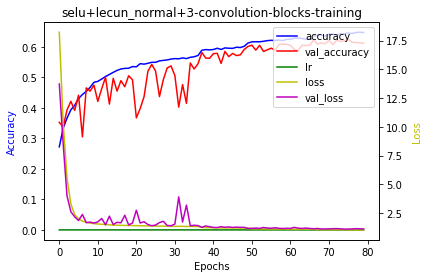

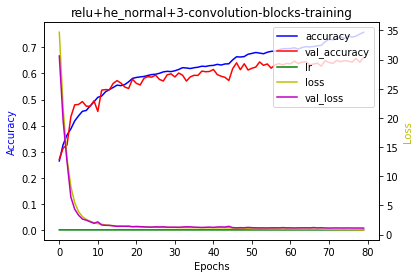

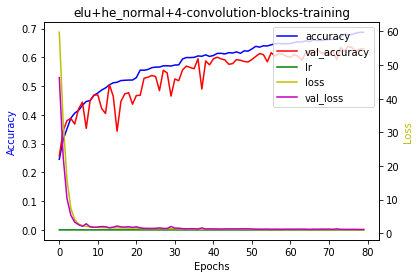

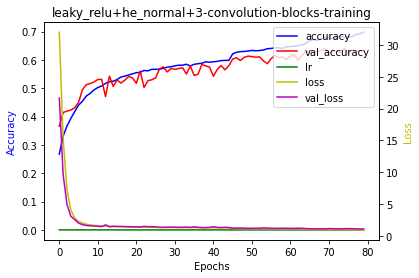

In [14]:
for csv_file in glob("*-training.csv"):
    name = ".".join(csv_file.split(".")[:-1])
    training = pd.read_csv(csv_file, index_col="epoch")
    fig, ax1 = plt.subplots(1, 1)
    ax2 = ax1.twinx()
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy", color="b")
    ax2.set_ylabel("Loss", color="y")
    ax1.plot(training.index, training["accuracy"], "b-", label="accuracy")
    ax1.plot(training.index, training["val_accuracy"], "r-", label="val_accuracy")
    ax1.plot(training.index, training["lr"], "g-", label="lr")
    ax2.plot(training.index, training["loss"], "y-", label="loss")
    ax2.plot(training.index, training["val_loss"], "m-", label="val_loss")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2)
    plt.title(name)
    plt.savefig(name + ".png")

### Copy models to Google Drive

In [20]:
for f in glob("*.csv*") + glob("*.png") + glob("*.json") + glob("*.h5"):
    shutil.copy(f, GOOGLE_DRIVE_PATH)
    print(f)

elu+he_normal+3-convolution-blocks-training.csv
selu+lecun_normal+4-convolution-blocks-training.csv
relu+he_normal+4-convolution-blocks-training.csv
leaky_relu+he_normal+4-convolution-blocks-training.csv
selu+lecun_normal+3-convolution-blocks-training.csv
relu+he_normal+3-convolution-blocks-training.csv
elu+he_normal+4-convolution-blocks-training.csv
leaky_relu+he_normal+3-convolution-blocks-training.csv
relu+he_normal+3-convolution-blocks-training.png
leaky_relu+he_normal+4-convolution-blocks-training.png
elu+he_normal+3-convolution-blocks-training.png
selu+lecun_normal+3-convolution-blocks-training.png
elu+he_normal+4-convolution-blocks-training.png
leaky_relu+he_normal+3-convolution-blocks-training.png
relu+he_normal+4-convolution-blocks-training.png
selu+lecun_normal+4-convolution-blocks-training.png
relu+he_normal+4-convolution-blocks.json
elu+he_normal+3-convolution-blocks.json
leaky_relu+he_normal+4-convolution-blocks.json
selu+lecun_normal+4-convolution-blocks.json
elu+he_norma